In [2]:
import numpy as np
from helper import *
from helper_dep import *
from helper_indep import *
from helper_shapley_sampling import *
from helper_kshap import *
import matplotlib.pyplot as plt
from scipy import stats

from os.path import join
import warnings 

warnings.filterwarnings('ignore')

## Generate data
### Data will have dependency, but we'll run both methods on it

In [3]:
d = 10
FEATURE_MEANS = np.repeat(0, d)
FEATURE_VARS = np.repeat(1, d)
FEATURE_COVS = [0.5, 0.25]
COV_MAT = make_banded_cov(FEATURE_VARS, FEATURE_COVS)

# Randomly generate samples
np.random.seed(1)
X = np.random.multivariate_normal(FEATURE_MEANS, COV_MAT, size=1000)
feature_means = np.mean(X, axis=0)
cov_mat = np.cov(X, rowvar=False)
xloc = np.random.multivariate_normal(FEATURE_MEANS, COV_MAT, size=1)

## Define Logistic Regression model
- All we need is the $d$ coefficients
- We don't need to actually fit the model; pretend it represents some $\{(X_i,Y_i)\}_{i=1}^n$

In [10]:
np.random.seed(1)
BETA = np.random.normal(0, 1, size = d)
def model(x):
    yhat = sigmoid(np.dot(x, BETA))
    return yhat.item() if x.shape[0]==1 else yhat

### Compute gradient & hessian of model w.r.t. local x

In [11]:
gradient = logreg_gradient(model, xloc, BETA)
hessian = logreg_hessian(model, xloc, BETA)

# Assume Independent Features
### Compute SHAP values of the quadratic approximation; verify they add up to $f(x)-Ef(X)$

In [61]:
avg_CV_empirical = np.mean(f_second_order_approx(model,X, xloc, gradient, hessian))
pred = model(xloc)
exp_CV_sum_empirical = pred - avg_CV_empirical
shap_CV_true_indep = compute_true_shap_cv_indep(xloc, gradient, hessian, feature_means, cov_mat)
sum_shap_CV_true = np.sum(shap_CV_true_indep)
print(sum_shap_CV_true)
print(exp_CV_sum_empirical) # Yes, they're extremely close

0.5683931171940729
0.568025859116221


## Shapley Sampling values, assuming independent features
### Specify number of permutations
- Don't need to give it true SHAP values of control variate; it computes them inside the function as above.

In [45]:
np.random.seed(1)
independent_features = True
obj_ss = cv_shapley_sampling(model, X, xloc, 
                        independent_features,
                        gradient, hessian,
                        M=100, n_samples_per_perm=10) # M is number of permutations
final_ests, vshap_ests_model, vshap_ests_CV, corr_ests = obj_ss
print(corr_ests) # Pretty solid correlations
print(np.round(100*(corr_ests**2))) # Variance reductions

[0.74841213 0.58340116 0.71671543 0.76364799 0.73335419 0.61385518
 0.60401438 0.4686495  0.49178817 0.45943482]
[56. 34. 51. 58. 54. 38. 36. 22. 24. 21.]


### Run until convergence
- A SHAP estimate converges when its standard deviation, normalized by its absolute value, is below the given threshold.
- Features with lowest SHAP values take longest to converge 

In [46]:
np.random.seed(1)
%run helper_shapley_sampling
obj_ss_auto = cv_shapley_sampling(model, X, xloc, 
                        independent_features,
                        gradient, hessian,
                        shap_CV_true=None, # Unnecessary; function calls compute_true_shap_cv_indep() 
                        M=None, n_samples_per_perm=10,
                        t=0.1, n_intermediate=50, # t is cutoff threshold; n_intermediate is evaluation frequency
                        verbose=True) # prints frequency of convergence for each feature
final_ests, vshap_ests_model, vshap_ests_CV, corr_ests = obj_ss_auto
print(corr_ests) # Similarly solid correlations
print(rank_shap(final_ests)) # SHAP values, highest to lowest

Converged with 2850 samples.
Converged with 200 samples.
Converged with 100 samples.
Converged with 100 samples.
Converged with 50 samples.
Converged with 50 samples.
Converged with 900 samples.
Converged with 100 samples.
Converged with 50 samples.
Converged with 50 samples.
[0.7292609  0.64567386 0.78242192 0.71646605 0.79788641 0.77825874
 0.68160953 0.49530593 0.71042645 0.49918904]
[5 4 3 7 9 2 6 1 8 0]


## KernelSHAP, Assuming Indepdent Features
### Specifying number of permutations
- Estimates variance and covariance of vanilla SHAP estimates via 250 bootstrapped samples. This is the default for kernelSHAP.

In [47]:
np.random.seed(1)
obj_kshap = cv_kshap(model, X, xloc, 
            independent_features,
            gradient, hessian,
            M=1000, n_samples_per_perm=10, 
            var_method='boot', n_boot=250)
final_ests, vshap_ests_model, vshap_ests_CV, corr_ests = obj_kshap
print(np.round(100*(corr_ests**2))) # Variance reductions
print(rank_shap(final_ests)) # Same ranking on important features

[63. 67. 65. 64. 54. 59. 58. 67. 60. 54.]
[5 4 7 3 9 2 1 0 6 8]


### Run until convergence
- KernelSHAP converges when 
$\displaystyle \frac{\max_j \sigma(\hat{\varphi}_j)}{\max_j \hat{\varphi}_j - \min_j \hat{\varphi}_j} < t$.

    - That is, when the highest standard deviation of a feature, normalized by the difference between highest and lowest SHAP estimates, is below the given threshold.

In [49]:
np.random.seed(1)
obj_kshap = cv_kshap(model, X, xloc, 
            independent_features,
            gradient, hessian,
            M=None,n_samples_per_perm=10,
            t=0.05, n_intermediate=50,
            verbose=True)
final_ests, vshap_ests_model, vshap_ests_CV, corr_ests = obj_kshap
print(np.round(100*(corr_ests**2))) # Variance reductions
print(rank_shap(final_ests)) # Same ranking on important features

Converged with 300 samples.
[83. 53. 65. 73. 49. 66. 78. 64. 61. 65.]
[5 4 7 3 9 2 6 1 0 8]


### Grouped covariance
- For more info on grouping, see the document I compiled.

In [53]:
np.random.seed(1)
obj_kshap_grouped = cv_kshap(model, X, xloc, 
            independent_features,
            gradient, hessian,
            M=1000, n_samples_per_perm=10, 
            var_method='grouped', K=50)
final_ests, vshap_ests_model, vshap_ests_CV, corr_ests = obj_kshap_grouped
print(np.round(100*(corr_ests**2))) # Variance reductions
print(rank_shap(final_ests)) # Same ranking on important features

[80. 69. 92. 65. 64. 47. 29. 75. 32. 69.]
[5 4 7 3 9 2 0 1 6 8]


### WLS covariance
- Something is clearly wrong with the estimated correlations, so WLS is not my method of choice.
- Perhaps it's worth unboxing what's going on here. Not only are they the same for all features, they're all > 1 too.

In [57]:
np.random.seed(1)
obj_kshap_wls = cv_kshap(model, X, xloc, 
            independent_features,
            gradient, hessian,
            M=1000, n_samples_per_perm=10, 
            var_method='wls')
final_ests, vshap_ests_model, vshap_ests_CV, corr_ests = obj_kshap_wls
print(corr_ests)
print(rank_shap(final_ests))

[1.91157776 1.91157776 1.91157776 1.91157776 1.91157776 1.91157776
 1.91157776 1.91157776 1.91157776 1.91157776]
[5 4 7 3 9 0 2 8 1 6]


# Dependent Features methods
## Estimate matrices used to approximate true SHAP values of linear model
- This should be computationally intensive, since we can reuse it for many local x
- Slow, since each permutation entails a matrix inversion

In [59]:
D_matrices = make_all_lundberg_matrices(10000, cov_mat) # Takes a while


### Compute almost-true SHAP values of linear model; verify their sum is close to $f(x)-Ef(X)$

In [60]:
avg_CV_empirical = np.mean(f_first_order_approx(model,X, xloc, gradient))
pred = model(xloc)
exp_CV_sum_empirical = pred - avg_CV_empirical

avg_model_empirical = np.mean(model(X))
exp_model_sum_empirical = pred - avg_model_empirical
shap_CV_true_dep = linear_shap_vals(xloc, D_matrices, feature_means, gradient)
sum_shap_CV_true = np.sum(shap_CV_true_dep)
print(exp_CV_sum_empirical)
print(sum_shap_CV_true)

0.1728154269465002
0.17172542971053537


## Shapley Sampling values, assuming dependent features
- For the sake of brevity, I won't show auto-convergence again.

In [71]:
np.random.seed(1)
independent_features = False
shap_CV_true_dep = linear_shap_vals(xloc, D_matrices, feature_means, gradient)
obj_dep = cv_shapley_sampling(model, X, xloc,
                    independent_features,
                    gradient, # Don't need to give hessian, since CV is linear model 
                    shap_CV_true=shap_CV_true_dep, # Equivalently, can give D_matrices instead
                    M=100,n_samples_per_perm=10)
final_ests, vshap_ests_model, vshap_ests_CV, corr_ests = obj_dep
print(corr_ests)
print(rank_shap(final_ests))

[0.93405594 0.94232004 0.96360638 0.94130982 0.93465167 0.95843532
 0.93519812 0.94732707 0.9318815  0.96076575]
[5 7 6 3 4 0 9 1 8 2]


## KernelSHAP values, assuming dependent features
- Recall default method for variance estimation is bootstrapping w/ 250 resamplings.
    - For the sake of brevity, I won't show alternatives again.

In [74]:
np.random.seed(1)
obj_kshap_dep = cv_kshap(model, X, xloc,
                    independent_features,
                    gradient,
                    shap_CV_true=shap_CV_true_dep,
                    M=1000,n_samples_per_perm=10)
final_ests, vshap_ests_model, vshap_ests_CV, corr_ests = obj_kshap_dep
print(corr_ests)
print(rank_shap(final_ests))

[0.93951184 0.94745438 0.94722257 0.94507995 0.92577878 0.94052093
 0.93404105 0.92126558 0.92333779 0.92353307]
[5 3 4 7 6 9 0 2 1 8]


# Empirical variance reductions
- We also can do this for Shapley Sampling or independent features. I'll just show it once, though.
    - Takes ~20 seconds to run
    
### I present 2 ways of estimating the correlation
1. "Average correlation" refers to taking the mean correlation across all iterations, for each feature
    - We can do this because each iteration estimates the correlation between vanilla SHAP estimates of the model & its approximation
2. "Correlation between observations" refers to taking the correlation between those vanilla SHAP estimates across all iterations
    - Unsurprisingly, it's less stable and closer to the empirical variance reduction


In [76]:
np.random.seed(1)
n_iter = 50
independent_features = False
objs_kshap_dep = []
for _ in range(n_iter):
    obj_dep = cv_kshap(model, X, xloc,
                    independent_features,
                    gradient,
                    shap_CV_true=shap_CV_true_dep,
                    M=500,n_samples_per_perm=10)
    objs_kshap_dep.append(obj_dep)

Empirical variance reductions:
• [0.79 0.89 0.92 0.78 0.84 0.87 0.81 0.87 0.82 0.87]
• Average:  0.85
-------------------- 
Method 1: Estimating correlation for each iteration, then averaging
Average correlations:
•  [0.928 0.923 0.928 0.933 0.921 0.931 0.919 0.917 0.927 0.924]
Theoretical variance reductions:
• [0.86 0.85 0.86 0.87 0.85 0.87 0.84 0.84 0.86 0.85]
• Average:  0.86
-------------------- 
Method 2: Taking correlation of observed Shapley values
Correlations
•  [0.894 0.944 0.959 0.899 0.932 0.936 0.906 0.934 0.91  0.937]
Theoretical variance reductions:
• [0.8  0.89 0.92 0.81 0.87 0.88 0.82 0.87 0.83 0.88]
• Average:  0.86


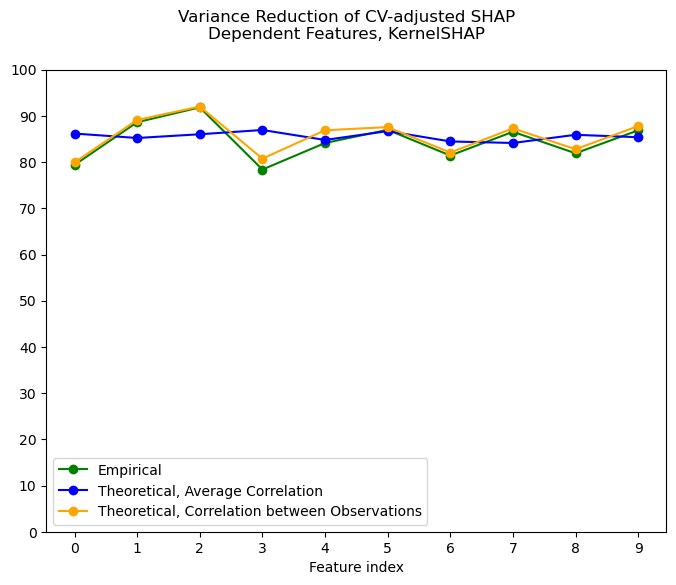

In [78]:
message = "Dependent Features, KernelSHAP"
show_var_reducs(objs_kshap_dep, ylim_zero=True, message=message, verbose=True)